In [12]:
# download modsim.py if necessary

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://github.com/AllenDowney/ModSimPy/raw/master/modsim.py')

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d

In [14]:
np.random.seed(42)

time_points = np.arange(0, 240, 15)

solute_concentration = 10 * np.exp(-0.01 * time_points) + np.random.normal(0, 0.5, len(time_points))

In [15]:
dialysis_data = pd.DataFrame({'time': time_points, 'solute': solute_concentration})


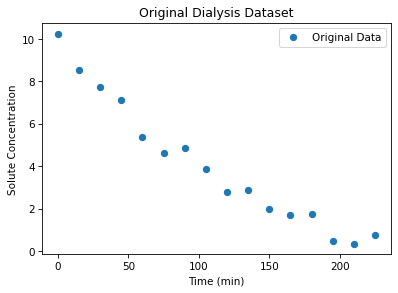

In [16]:
plt.plot(dialysis_data['time'], dialysis_data['solute'], 'o', label='Original Data')
plt.xlabel('Time (min)')
plt.ylabel('Solute Concentration')
plt.title('Original Dialysis Dataset')
plt.legend()
plt.show()


In [17]:
initial_concentration = 15
k_dialysis = 0.01

In [18]:
dialysis_system = System(init=State(concentration=initial_concentration), params=k_dialysis,
                         t_0=t_0, t_end=t_end, dt=2)


In [19]:
def run_simulation(system, update_func):
    t_array = np.arange(system.t_0, system.t_end, system.dt)
    n = len(t_array)

    frame = pd.DataFrame(index=t_array, columns=system.init.index)
    frame.iloc[0] = system.init

    for i in range(n-1):
        t = t_array[i]
        state = frame.iloc[i]
        frame.iloc[i+1] = update_func(t, state, system)

    return frame

In [20]:
def dialysis_update_func(t, state, system):
    concentration, = state
    k_dialysis = system.params
    dt = system.dt

    dcdt = -k_dialysis * concentration
    concentration += dcdt * dt

    return State(concentration=concentration)

In [21]:
dialysis_results = run_simulation(dialysis_system, dialysis_update_func)


In [22]:
def dialysis_slope_func(t, state, system):
    concentration, = state
    k_dialysis = system.params

    dcdt = -k_dialysis * concentration

    return dcdt

In [23]:
dialysis_results_solve_ivp, _ = run_solve_ivp(dialysis_system, dialysis_slope_func,
                                             t_eval=dialysis_results.index)

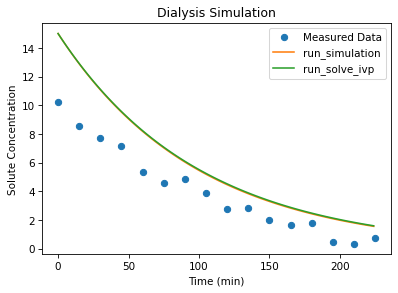

In [24]:
plt.plot(dialysis_data['time'], dialysis_data['solute'], 'o', label='Measured Data')
plt.plot(dialysis_results.index, dialysis_results['concentration'], label='run_simulation')
plt.plot(dialysis_results_solve_ivp.index, dialysis_results_solve_ivp['concentration'], label='run_solve_ivp')
plt.xlabel('Time (min)')
plt.ylabel('Solute Concentration')
plt.title('Dialysis Simulation')
plt.legend()
plt.show()